## Logistic Regression - Titanic

The titanic dataset is a popular dummy dataset used to learn about logistic regression. It has also been used in a [Kaggle data science competition](https://www.kaggle.com/c/titanic), so you'll also find blogposts exploring all kinds of more advanced concepts that use this dataset too! In this assignment, you'll do a logistic regression to look at the effect of sex and class on survival on the titanic, by computing odds ratios.

adapted from: https://github.com/jstray/lede-algorithms/blob/master/week-3/week-3-2-homework.ipynb

Some references:

- [What are odds vs. probability?](https://towcenter.gitbooks.io/curious-journalist-s-guide-to-data/content/analysis/counting_possible_worlds.html)
- [Investigate.ai on Logistic Regressions](https://investigate.ai/regression/logistic-regression-quickstart/)
- [StatQuest Logistic Regressions Playlist](https://www.youtube.com/watch?v=yIYKR4sgzI8&list=PLblh5JKOoLUKxzEP5HA2d-Li7IJkHfXSe)
- [How do I interpret odds ratios in logistic regression?](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/) This one's a little more technical, but has good examples.


In [1]:
import pandas as pd
import numpy as np 
from plotnine import *

### Load the data

Read in the `titanic.csv` data set again.

In [2]:
# Load titanic.csv
df = pd.read_csv('titanic.csv')
df

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender
0,1st,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female
1,1st,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
2,1st,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male
3,1st,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
4,1st,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male
...,...,...,...,...,...,...,...,...,...,...
1308,3rd,0,"Zakarian, Mr Artun",NaN,NaN,NaN,NaN,NaN,NaN,male
1309,3rd,0,"Zakarian, Mr Maprieder",NaN,NaN,NaN,NaN,NaN,NaN,male
1310,3rd,0,"Zenn, Mr Philip",NaN,NaN,NaN,NaN,NaN,NaN,male
1311,3rd,0,"Zievens, Rene",NaN,NaN,NaN,NaN,NaN,NaN,female


The first thing we need to do is code the pclass and gender variables numerically. Let's use the following scheme:
- pclass: 1,2,3
- gender: 0=male, 1=female, and let's call the column called "female" to remind us which is which

In [3]:
# recode the pclass and gender variables so they are numeric
df['pclass'] = df.pclass.replace({'1st': 1, '2nd': 2, '3rd': 3})
df['female'] = df.gender.replace({'male': 0, 'female': 1})
df.head(3)

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female
0,1,1,"Allen, Miss Elisabeth Walton",29.0,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1
1,1,0,"Allison, Miss Helen Loraine",2.0,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0


### 1. Exploratory data analysis

In [4]:
df.head()

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0


In [5]:
# First, let's do some descriptive stats
# 
# How many men and women are travelling on the titanic?
# How many people are travelling in each class?
# What share of each survived?
piv = df.pivot_table(index='survived', columns='female', aggfunc='count', values='name')
display(piv)

pct_survived = piv.apply(lambda x: x/sum(x)).round(2)
display(pct_survived)

female,0,1
survived,,
0,708,156
1,142,307


female,0,1
survived,,
0,0.83,0.34
1,0.17,0.66


### 2. Logistic regression with one variable at a time

First, do a logistic regression of the `female` variable alone to predict the probability of survival. Below is some code that will help you plot the result.

In [51]:
# Step 1: Run a logistic regression on one variable and see the summary of the output
import statsmodels.formula.api as smf

model = smf.logit("survived ~ female + age + pclass", data=df)
results = model.fit()
results.summary()

coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})
coefs
# hint: 
# https://investigate.ai/regression/logistic-regression-quickstart/#Performing-a-regression

Optimization terminated successfully.
         Current function value: 0.426398
         Iterations 6


,coef,odds ratio,pvalue,name
Intercept,2.818805,16.756822,1.907179e-08,Intercept
female,3.086188,21.893452,1.860397e-37,female
age,-0.048867,0.952308,1.403173e-08,age
pclass,-1.422401,0.241134,4.998668e-17,pclass


In [7]:
# Step 2: analyze the dataframe with predicted values

df['prediction'] = results.predict(df['female'])
df
# hint: 
# you'll need to create a new column on df and use results.predict() to assign it values
# https://investigate.ai/regression/logistic-regression-quickstart/#Making-predictions

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.663067
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.663067
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.167059
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.663067
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.167059
...,...,...,...,...,...,...,...,...,...,...,...,...
1308,3,0,"Zakarian, Mr Artun",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.167059
1309,3,0,"Zakarian, Mr Maprieder",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.167059
1310,3,0,"Zenn, Mr Philip",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.167059
1311,3,0,"Zievens, Rene",NaN,NaN,NaN,NaN,NaN,NaN,female,1,0.663067


In [8]:
# Step 3: What is the odds ratio of on the gender variable alone?


coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})
coefs
# hint: in order to make sense of the coefficients, you'll need to exponentiate them
# that turns the coefficients into odds ratios
# https://investigate.ai/regression/logistic-regression-quickstart/#Converting-coefficient-to-odds


,coef,odds ratio,pvalue,name
Intercept,-1.606617,0.200565,2.306853e-68,Intercept
female,2.283609,9.812026,1.529597e-64,female


Now, try the same thing but with the `pclass` variable

In [9]:
# Step 1: Run a logistic regression on one variable and see the summary of the output

# Step 1: Run a logistic regression on one variable and see the summary of the output
import statsmodels.formula.api as smf

model = smf.logit("survived ~ pclass", data=df)
results = model.fit()
results.summary()

coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})
coefs
# hint: 
# https://investigate.ai/regression/logistic-regression-quickstart/#Performing-a-regression

# hint: 
# https://investigate.ai/regression/logistic-regression-quickstart/#Performing-a-regression

Optimization terminated successfully.
         Current function value: 0.576759
         Iterations 5


,coef,odds ratio,pvalue,name
Intercept,1.399625,4.053680,1.778696e-16,Intercept
pclass,-0.928532,0.395133,1.832570e-36,pclass


In [10]:
# Step 2: analyze the dataframe with predicted values



df['prediction'] = results.predict(df['pclass'])
df
# hint: 
# you'll need to create a new column on df and use results.predict() to assign it values
# https://investigate.ai/regression/logistic-regression-quickstart/#Making-predictions

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.615642
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.615642
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.615642
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.615642
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.615642
...,...,...,...,...,...,...,...,...,...,...,...,...
1308,3,0,"Zakarian, Mr Artun",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.200052
1309,3,0,"Zakarian, Mr Maprieder",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.200052
1310,3,0,"Zenn, Mr Philip",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.200052
1311,3,0,"Zievens, Rene",NaN,NaN,NaN,NaN,NaN,NaN,female,1,0.200052


In [11]:
# Step 3: What is the odds ratio of on the pclass variable alone?

# hint: in order to make sense of the coefficients, you'll need to exponentiate them
# that turns the coefficients into odds ratios
# https://investigate.ai/regression/logistic-regression-quickstart/#Converting-coefficient-to-odds


**Bonus** 🤖 - Writing clean/DRY code

DRY stands for "Don't Repeat Yourself". This is a good principle of writing clean code. Instead of copy/pasting code multiple times (which can lead to errors if you fix one copy but not the other), you can write DRY code by wrapping any chunk of code you plan to repeat in a function. As a bonus on this section, re-write the code above as a function and run that function once on `female` and once on `pclass`.

### 3. Looking at two variables at a time

We know from the earlier assignment that class also affects survival, so let's add that to our model. Compute a logistic regression on the variables `pclass` and `female`.

In [12]:
# Logistic regression on two variables

# hint: 
# https://investigate.ai/regression/logistic-regression-quickstart/#Performing-a-regression

In [13]:
# Step 2: analyze the dataframe with predicted values

# hint: 
# you'll need to create a new column on df and use results.predict() to assign it values
# https://investigate.ai/regression/logistic-regression-quickstart/#Making-predictions

In [14]:
# Step 3: What is the odds ratio of on the gender variable?

# hint: in order to make sense of the coefficients, you'll need to exponentiate them
# that turns the coefficients into odds ratios
# https://investigate.ai/regression/logistic-regression-quickstart/#Converting-coefficient-to-odds

### 4. What does this mean

What is the odds ratio on the `pclass` variable? What happens to the odds of survival when we move from 1st to 2nd or from 2nd to 3rd class?


In [17]:
👉
df

SyntaxError: invalid character '👉' (U+1F449) (1279766307.py, line 1)

### 5. Bonus - Age

Does the age of a passenger impact their chances of survival?

<AxesSubplot:>

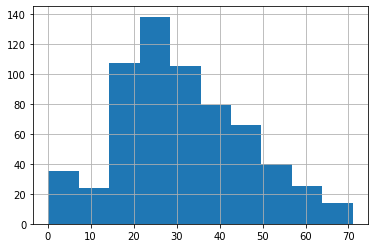

In [20]:
df['age'].hist()

In [31]:
survived = df[df['survived'] == 1]
died = df[df['survived'] == 0]

<AxesSubplot:>

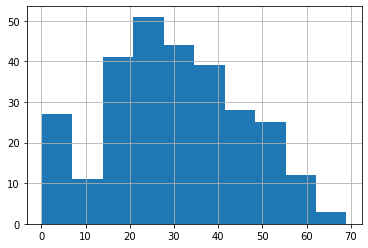

In [28]:
survived['age'].hist()

<AxesSubplot:>

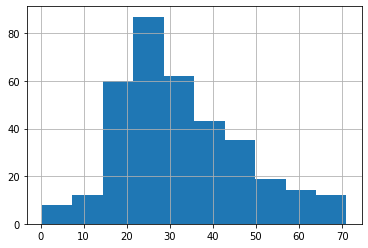

In [33]:
died['age'].hist()

In [35]:
import statsmodels.api as sm

Y = df['survived']
X = df['age']



model = sm.OLS(Y, X, missing='drop')
model_result = model.fit()
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               survived   R-squared (uncentered):                   0.333
Model:                            OLS   Adj. R-squared (uncentered):              0.332
Method:                 Least Squares   F-statistic:                              315.3
Date:                Fri, 08 Apr 2022   Prob (F-statistic):                    1.56e-57
Time:                        15:05:41   Log-Likelihood:                         -513.05
No. Observations:                 633   AIC:                                      1028.
Df Residuals:                     632   BIC:                                      1033.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0111      0.001     17.757      0.000       0.010       0.012
==============================================================================
Omnibus:                     4105.033   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.872
Skew:                           0.212   Prob(JB):                     6.72e-16
Kurtosis:                       1.429   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
model = smf.ols("survived ~ age + female + pclass", data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     166.4
Date:                Fri, 08 Apr 2022   Prob (F-statistic):           2.21e-79
Time:                        15:16:20   Log-Likelihood:                -270.55
No. Observations:                 633   AIC:                             549.1
Df Residuals:                     629   BIC:                             566.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8236      0.067     12.208      0.000       0.691       0.956
age           -0.0067      0.001     -6.022      0.000      -0.009      -0.005
female         0.5596      0.031     18.158      0.000       0.499       0.620
pclass        -0.1975      0.020     -9.723      0.000      -0.237      -0.158
==============================================================================
Omnibus:                       13.638   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.114
Skew:                           0.328   Prob(JB):                     0.000861
Kurtosis:                       3.324   Cond. No.                         164.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
model = smf.ols("survived ~ age:female + pclass + age + female", data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     133.9
Date:                Fri, 08 Apr 2022   Prob (F-statistic):           1.14e-82
Time:                        15:17:11   Log-Likelihood:                -260.21
No. Observations:                 633   AIC:                             530.4
Df Residuals:                     628   BIC:                             552.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9439      0.071     13.208      0.000       0.804       1.084
age:female     0.0093      0.002      4.565      0.000       0.005       0.013
pclass        -0.1998      0.020     -9.985      0.000      -0.239      -0.160
age           -0.0104      0.001     -7.632      0.000      -0.013      -0.008
female         0.2723      0.070      3.897      0.000       0.135       0.409
==============================================================================
Omnibus:                       16.239   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.072
Skew:                           0.360   Prob(JB):                     0.000196
Kurtosis:                       3.358   Cond. No.                         221.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
df['age'].describe()


count    633.000000
mean      31.194181
std       14.747525
min        0.166700
25%       21.000000
50%       30.000000
75%       41.000000
max       71.000000
Name: age, dtype: float64

In [50]:
df['age_cat'] = df['age'] 